In [336]:
import numpy as np
import pandas as pd
import matplotlib as plt
import geopandas as gpd # conda install geopandas
from geopandas.tools import sjoin
import shapely
from shapely.geometry import Point, Polygon
import folium # conda install -c conda-forge folium
import json
import pickle
import geopy
from geopy.extra.rate_limiter import RateLimiter
import re
import requests
import functools
import matplotlib.pyplot as plt

### Import data
We import the dataset containing the food inspection and drop all irrelevant and null columns.

In [446]:
data = pd.read_csv('data/food-inspections.csv').drop(['AKA Name', 'City', 'State', "Historical Wards 2003-2015", "Zip Codes", "Community Areas", "Census Tracts", "Wards", "Location"], axis=1)
data.head()

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,2320509,TAQUERIA EL DORADO,2694960.0,Restaurant,Risk 1 (High),2114 W LAWRENCE AVE,60625.0,2019-10-25T00:00:00.000,License Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968820,-87.682292
1,2320519,SALAM RESTAURANT,2002822.0,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,60625.0,2019-10-25T00:00:00.000,Complaint Re-Inspection,Pass,NaN,41.965719,-87.708538
2,2320421,THE NEW GRACE RESTAURANT,2698310.0,Restaurant,Risk 1 (High),4409 N BROADWAY,60640.0,2019-10-24T00:00:00.000,License,Not Ready,NaN,41.962104,-87.655204
3,2320368,GADS HILL CHILD CARE CENTER,2215799.0,Children's Services Facility,Risk 1 (High),2653 W OGDEN AVE,60608.0,2019-10-24T00:00:00.000,License,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.862273,-87.692703
4,2320389,"ALL THINGS ARE POSSIBLE FOR KIDS, INC.",2215965.0,Children's Services Facility,Risk 1 (High),4014 W CHICAGO AVE,60651.0,2019-10-24T00:00:00.000,License,Pass,54. GARBAGE & REFUSE PROPERLY DISPOSED; FACILI...,41.895468,-87.726665


# Complete the dataset

## Duplicates
Entries must be identified by their Inspection ID. Duplicate rows can simply be removed.

In [447]:
print("Number of duplicate inspection IDs: " + str(len(data[data.duplicated("Inspection ID")])))
data = data.drop_duplicates()
print("Number of duplicate inspection IDs after removal: " + str(len(data[data.duplicated("Inspection ID")])))

Number of duplicate inspection IDs: 196
Number of duplicate inspection IDs after removal: 0


## Deal with missing values

In [399]:
for col in data.columns:
    print("Number of null entries for " + col + ":" + str(len(data[data[col].apply(pd.isnull)])))
    if isinstance(data[col][0], str):
        print("Number of empty string entries for " + col + ":" + str(len(data[data[col].apply(str).apply(str.isspace)])))

Number of null entries for Inspection ID:0
Number of null entries for DBA Name:0
Number of empty string entries for DBA Name:0
Number of null entries for License #:0
Number of null entries for Facility Type:0
Number of empty string entries for Facility Type:0
Number of null entries for Risk:5
Number of empty string entries for Risk:0
Number of null entries for Address:0
Number of empty string entries for Address:2
Number of null entries for Zip:22
Number of null entries for Inspection Date:0
Number of empty string entries for Inspection Date:0
Number of null entries for Inspection Type:1
Number of empty string entries for Inspection Type:0
Number of null entries for Results:0
Number of empty string entries for Results:0
Number of null entries for Violations:31535
Number of empty string entries for Violations:0
Number of null entries for Latitude:170
Number of null entries for Longitude:170
Number of null entries for Year:0


### Address
There are some addresses that are missing in that they only contain a few spaces.

In [7]:
data[data['Address'].apply(str.isspace)]

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
69601,1763245,EAT N RUN CHICKEN AND FISH,2442868.0,Restaurant,Risk 1 (High),,NaN,2016-04-19T00:00:00.000,License,Not Ready,NaN,NaN,NaN
189113,114452,Starfruit Cafe,2031651.0,NaN,Risk 2 (Medium),,60654.0,2010-05-05T00:00:00.000,License,Fail,NaN,NaN,NaN
190589,60405,CASA CENTRAL LA POSADA,0.0,Restaurant,Risk 1 (High),,NaN,2010-04-05T00:00:00.000,Canvass,Pass,37. TOILET ROOM DOORS SELF CLOSING: DRESSING R...,NaN,NaN


### Latitude and longitude
There are entries that are missing coordinate data, which is needed to put them on the map.
We see that all entries have address data, so we try to fill in the null values for the coordinates by using Geopy that uses geocoders to get coordinates based on addresses. Through testing we found that using ArcGIS as a geocoder gives us a perfect result.

In [8]:
locator = geopy.geocoders.ArcGIS(user_agent='myGeocoder')
data_wo_latlong = data[data['Latitude'].apply(np.isnan)].groupby("DBA Name").first()
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
lats = pd.Series(index=data_wo_latlong.index)
longs = pd.Series(index=data_wo_latlong.index)
for name, address in list(zip(data_wo_latlong.index, data_wo_latlong['Address'])):
    if str.isspace(address):
        print('Empty address for ' + name + 'ignored')
        continue
    location = geocode(address + ", Chicago, United States")
    if location is not None:
        lats[name] = location.latitude
        longs[name] = location.longitude
    else:
        print('Did not find location for address: ' + address)

for name, lat, long in zip(lats.index, lats, longs):
    data['Latitude'] = np.where(data['DBA Name'] == name, lat, data['Latitude'])
    data['Longitude'] = np.where(data['DBA Name'] == name, long, data['Longitude'])

KeyboardInterrupt: 

In [9]:
print("Number of entries without coordinate data: " + str(len(data[data["Latitude"].apply(pd.isnull)])))
data[data["Latitude"].apply(pd.isnull)]

Number of entries without coordinate data: 682


,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
510,2315463,VEENO,2578370.0,Restaurant,Risk 2 (Medium),2009 S LAFIN ST,60608.0,2019-10-08T00:00:00.000,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",NaN,NaN
534,2315467,VEENO,2578371.0,Restaurant,Risk 3 (Low),2009 S LAFIN ST,60608.0,2019-10-08T00:00:00.000,License,Fail,NaN,NaN,NaN
1317,2312470,Carson (Old),22601.0,School,Risk 1 (High),5516 S Maplewood (2532W) AVE,60629.0,2019-09-18T00:00:00.000,Canvass Re-Inspection,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",NaN,NaN
1419,2312360,"PACINO'S RC, LLC",2683669.0,Restaurant,Risk 3 (Low),1010 S DELANO CT,60605.0,2019-09-16T00:00:00.000,License Re-Inspection,Pass,NaN,NaN,NaN
1472,2312357,"PACINO'S RC, LLC",2683667.0,Restaurant,Risk 1 (High),1010 S DELANO CT,60605.0,2019-09-16T00:00:00.000,License Re-Inspection,Pass,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194538,67840,TONTI ELEMENTARY,25631.0,School,Risk 1 (High),5815 S Homan (3400W) AVE,60629.0,2010-01-12T00:00:00.000,Canvass,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN
194624,158253,ARGENTINA FOODS,2009367.0,Grocery Store,Risk 2 (Medium),4500 S WOODS ST,60609.0,2010-01-11T00:00:00.000,License,Fail,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,NaN,NaN
194704,154225,Chartwells,1166638.0,Special Event,Risk 2 (Medium),2324 N FREMONT ST,60614.0,2010-01-07T00:00:00.000,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,NaN,NaN
194713,67788,Carson (Old),22601.0,School,Risk 1 (High),5516 S Maplewood (2532W) AVE,60629.0,2010-01-07T00:00:00.000,Canvass,Pass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",NaN,NaN


### Zip
We supplement the zip codes by finding where the coordinates belong in a GeoJSON boundary map for zip codes.

In [53]:
data[data['Zip'].apply(pd.isnull)].sample(10)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [54]:
map_zip = gpd.read_file('data/chicago_zip.geojson')
missing_zip = data[data['Zip'].apply(pd.isnull)].copy()
for index, lat, long in zip(missing_zip.index, missing_zip['Latitude'], missing_zip['Longitude']):
    for zip_code, mpoly in zip(map_zip.zip, map_zip.geometry): 
        for poly in mpoly:
            if poly.contains(Point(long,lat)): # Points in polygons have inverse lat, long
                missing_zip.at[index,'Zip'] = zip_code
data.update(missing_zip)

print("Number of entries without zip data: " + str(len(data[data['Zip'].apply(pd.isnull)])))
data[data['Zip'].apply(pd.isnull)]

Number of entries without zip data: 1


,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
123931,1106878.0,FILIPINO AMERICAN COUNCIL,2225427.0,Golden Diner,Risk 1 (High),1332 W DRIVING PARK ROAD BSMT,NaN,2013-09-26T00:00:00.000,Canvass,Out of Business,NaN,39.94981,-82.95809


### License number
We decide that license numbers are not important for our research. (???)

In [55]:
data[data['License #'].apply(pd.isnull)].sample(10)

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
39837,2071910.0,ST. DEMETRIOS GREEK ORTHODOX CHURCH,NaN,Special Event,Risk 2 (Medium),2727 W WINONA ST,60625.0,2017-08-04T00:00:00.000,Canvass,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.974653,-87.697529
184679,339207.0,ST DEMETRIOS CHURCH,NaN,Special Event,Risk 1 (High),2727 W WINONA ST,60625.0,2010-07-30T00:00:00.000,Special Events (Festivals),Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.974653,-87.697529
147647,1188285.0,ST. DEMETRIOS GREEK ORTHODOX CHURCH,NaN,Special Event,Risk 2 (Medium),2727 W WINONA ST,60625.0,2012-07-25T00:00:00.000,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.974653,-87.697529
113188,1152076.0,ARGENTINA FOODS,NaN,Grocery Store,Risk 2 (Medium),4500 S WOOD ST,60609.0,2014-04-10T00:00:00.000,Canvass,Out of Business,NaN,41.812074,-87.670247
127949,1099104.0,ST. DEMETRIOS GREEK ORTHODOX CHURCH,NaN,Special Event,Risk 2 (Medium),2727 W WINONA ST,60625.0,2013-07-24T00:00:00.000,Canvass,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.974653,-87.697529
154371,1214242.0,GOD'S BATTLE AXE PRAYER ACADEMY,NaN,CHURCH/DAY CARE,Risk 1 (High),6969 N WESTERN AVE,60645.0,2012-03-19T00:00:00.000,Canvass Re-Inspection,Pass,NaN,42.008303,-87.690005
22844,2181316.0,ST. DEMETRIOS GREEK ORTHODOX CHURCH,NaN,Special Event,Risk 2 (Medium),2727 W WINONA ST,60625.0,2018-06-13T00:00:00.000,Canvass,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.974653,-87.697529
65373,1933084.0,ST. DEMETRIOS GREEK ORTHODOX CHURCH,NaN,Special Event,Risk 2 (Medium),2727 W WINONA ST,60625.0,2016-06-20T00:00:00.000,Canvass,Pass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.974653,-87.697529
187278,229453.0,OLD ST. PATRICK'S CHURCH,NaN,Church,Risk 2 (Medium),700 W ADAMS ST,60661.0,2010-06-08T00:00:00.000,Special Events (Festivals),Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.879367,-87.644105
176442,417318.0,AVALON COMMUNITY CHURCH/FREEDOM HOME ACADEMY,NaN,CHURCH/AFTER SCHOOL PROGRAM,Risk 1 (High),8100 S DANTE AVE,60619.0,2011-01-10T00:00:00.000,Short Form Complaint,Fail,NaN,41.747711,-87.589539


### Facility Type
There are a lot of missing facility types.

In [62]:
null_facility = data[data['Facility Type'].apply(pd.isnull)]
null_facility

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
137,2316135.0,SHELL,2889767.0,NaN,Risk 3 (Low),6659 S WENTWORTH AVE,60621.0,2019-10-18T00:00:00.000,License,Not Ready,NaN,41.772809,-87.629820
171,2316086.0,UNIVERSITY CENTER PROPERTY LLC,2694616.0,NaN,NaN,525 S STATE ST,60605.0,2019-10-18T00:00:00.000,License,Not Ready,NaN,41.875179,-87.627474
242,2316011.0,DASH OF SALT AND PEPPER,2694886.0,NaN,Risk 1 (High),2201 N LINCOLN AVE,60614.0,2019-10-17T00:00:00.000,License,Not Ready,NaN,41.922056,-87.643811
275,2315957.0,G & J ICE CREAM,2622621.0,NaN,Risk 2 (Medium),6355 S WESTERN AVE,60636.0,2019-10-16T00:00:00.000,License,Not Ready,NaN,41.777509,-87.683450
296,2315960.0,MINGHIN JAPENESE,2670193.0,NaN,NaN,1232-1234 S MICHIGAN AVE,60605.0,2019-10-15T00:00:00.000,License,Not Ready,NaN,41.866541,-87.624281
...,...,...,...,...,...,...,...,...,...,...,...,...,...
194823,120276.0,BUTTER,1193256.0,NaN,Risk 3 (Low),130 S GREEN ST,60607.0,2010-01-06T00:00:00.000,Out of Business,Pass,NaN,41.879501,-87.648608
194841,160208.0,"LOVEBUGS, TODDLER PROGRAMS AND PRESCHOOL, LLC",1820997.0,NaN,Risk 1 (High),1327 N LARRABEE ST,60610.0,2010-01-05T00:00:00.000,Out of Business,Pass,NaN,41.905866,-87.643136
194861,70272.0,THE DOGHOUSE,1681450.0,NaN,Risk 1 (High),11601 W TOUHY AVE,60666.0,2010-01-05T00:00:00.000,Out of Business,Pass,NaN,42.008536,-87.914428
194862,67760.0,MC INTOSH'S,1648623.0,NaN,Risk 1 (High),748 W 61ST ST,60621.0,2010-01-05T00:00:00.000,Out of Business,Fail,NaN,41.783503,-87.644386


In [79]:
null_facility.groupby('Results').count().rename(columns={"DBA Name": "Count"})["Count"]

Results
Business Not Located      26
Fail                     367
No Entry                  71
Not Ready                 89
Out of Business         3915
Pass                     260
Pass w/ Conditions        42
Name: Count, dtype: int64

### Risk

In [80]:
null_risk = data[data['Risk'].apply(pd.isnull)]
null_risk

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
171,2316086.0,UNIVERSITY CENTER PROPERTY LLC,2694616.0,NaN,NaN,525 S STATE ST,60605.0,2019-10-18T00:00:00.000,License,Not Ready,NaN,41.875179,-87.627474
296,2315960.0,MINGHIN JAPENESE,2670193.0,NaN,NaN,1232-1234 S MICHIGAN AVE,60605.0,2019-10-15T00:00:00.000,License,Not Ready,NaN,41.866541,-87.624281
930,2312988.0,COTTAGE GROVE FOOD LLC,2677374.0,NaN,NaN,8207 S COTTAGE GROVE,60619.0,2019-09-26T00:00:00.000,License,No Entry,NaN,41.745539,-87.604930
1300,2312532.0,CHICAGO MERCANTILE EXCHANGE INC.,2690163.0,NaN,NaN,20 S WACKER DR,60606.0,2019-09-18T00:00:00.000,License,Not Ready,NaN,41.881564,-87.637160
1681,2312059.0,CRAFTY CAFE,2689277.0,Restaurant,NaN,225 W WACKER DR,60606.0,2019-09-11T00:00:00.000,License,Not Ready,NaN,41.886709,-87.634711
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190454,150313.0,JO JO FOOD MART,1868927.0,NaN,NaN,3801 N CICERO AVE,60641.0,2010-04-07T00:00:00.000,Out of Business,Pass,NaN,41.949826,-87.747058
190872,58405.0,SOCIAL CLUB,0.0,NaN,NaN,1105 N CALIFORNIA AVE,60622.0,2010-03-29T00:00:00.000,Short Form Complaint,Pass,NaN,41.901286,-87.696692
191212,58385.0,SOCIAL CLUB,0.0,NaN,NaN,1105 N CALIFORNIA AVE,60622.0,2010-03-22T00:00:00.000,Short Form Complaint,Pass,NaN,41.901286,-87.696692
191959,58356.0,SOCIAL CLUB,0.0,NaN,NaN,1105 N CALIFORNIA AVE,60622.0,2010-03-08T00:00:00.000,Short Form Complaint,Pass,NaN,41.901286,-87.696692


In [169]:
null_risk.groupby('Results').count().rename(columns={"DBA Name": "Count"})["Count"]

Results
Business Not Located     8
Fail                    22
No Entry                 7
Not Ready               20
Out of Business          3
Pass                    12
Name: Count, dtype: int64

In [170]:
null_risk.groupby('Facility Type').count().rename(columns={"DBA Name": "Count"})["Count"]

Facility Type
AFTER SCHOOL PROGRAM     1
CHICAGO PARK DISTRICT    1
CHURCH                   1
FARMER'S MARKET          1
FOOD PANTRY/CHURCH       2
Illegal Vendor           1
Mobile Food Dispenser    1
RETAIL                   1
Restaurant               5
WAREHOUSE                1
unlicensed facility      2
Name: Count, dtype: int64

### Inspection Type

In [171]:
data[data['Inspection Type'].apply(pd.isnull)]

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Facility Type Group,Results Group
63843,1946612.0,ARAMARL-FRESHII,2470318.0,Restaurant,Risk 1 (High),2650 N CLARK ST,60614.0,2016-07-14T00:00:00.000,NaN,Pass,NaN,41.930833,-87.644135,restaurant,pass


### Violations
Since there is no way we can know which violations have been done, we fill null values with "No data".

In [172]:
data[data['Violations'].apply(pd.isnull)].sample(10)
data['Violations'] = data['Violations'].fillna('No data')

# Information about columns

## Inspection types
From https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF:

Inspection type: An inspection can be one of the following types: 
* canvass, the most common type of inspection performed at a frequency relative to the risk of the establishment; 
* consultation, when the inspection is done at the request of the owner prior to the opening of the establishment; complaint, when  the inspection is done in response to a complaint against the establishment; 
* license, when the inspection is done as a requirement for the establishment to receive its license to operate; 
* suspect food poisoning, when the inspection is done in response to one or more persons claiming to have gotten ill as a result of eating at the establishment (a specific type of complaint-based inspection); 
* task-force inspection, when an inspection of a bar or tavern is done. 

Re-inspections can occur for most types of these inspections and are indicated as such.

In [226]:
inspection_types = data['Inspection Type'].drop_duplicates().reset_index(drop=True).apply(str)
valid_inspection_types = ['canvass', 'consultation', 'license', 'complaint', 'food poisoning', 'task']
pd.set_option('display.max_rows', 108)
print(inspection_types[inspection_types.apply(str.lower).map(lambda x: any([y in x for y in valid_inspection_types]))])
print(inspection_types[inspection_types.apply(str.lower).map(lambda x: not any([y in x for y in valid_inspection_types]))])
pd.reset_option('display.max_rows')

# What to do? We could manually annotate them since there are not too many. 
# We also need to figure out what a combination of types mean, for example "License-Task Force"
# Also, there are a few things that are not correctly classified using only keywords, for example "OWNER SUSPENDED OPERATION/LICENSE" will be classified as license

0                          License Re-Inspection
1                        Complaint Re-Inspection
2                                        License
3                                        Canvass
4                          Canvass Re-Inspection
6                                      Complaint
7                           Short Form Complaint
8                       Suspected Food Poisoning
9         Suspected Food Poisoning Re-inspection
11                                  Consultation
15                                fire complaint
19                            License-Task Force
20                  Complaint-Fire Re-inspection
21                                Complaint-Fire
22                     Short Form Fire-Complaint
26                     LICENSE CANCELED BY OWNER
27             OWNER SUSPENDED OPERATION/LICENSE
28                          LICENSE CONSULTATION
29                          License consultation
30                        Task Force Liquor 1475
34                  

## Results
From https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF:

An inspection can pass, pass with conditions or fail. Establishments receiving a ‘pass’ were found to have no critical or serious violations (violation number 1-14 and 15-29, respectively). Establishments receiving a ‘pass with conditions’ were found to have critical or serious violations, but these were corrected during the inspection. Establishments receiving a ‘fail’ were found to have critical or serious violations that were not correctable during the inspection. An establishment receiving a ‘fail’ does not necessarily mean the establishment’s licensed is suspended. Establishments found to be out of business or not located are indicated as such. 

We add the categories 'not ready' and 'no entry', which covers all result types.

In [404]:
results = data['Results'].apply(str)
results_unique = data['Results'].drop_duplicates().reset_index(drop=True).apply(str)
valid_results_strings = ['pass','pass w/ conditions','fail','out of business', 'business not located', 'not ready', 'no entry']
print('Valid results')
print(results_unique[results_unique.apply(str.lower).map(lambda x: any([y == x for y in valid_results_strings]))])
print('Invalid results')
print(results_unique[results_unique.apply(str.lower).map(lambda x: not any([y == x for y in valid_results_strings]))])

Valid results
0                    Fail
1                    Pass
2               Not Ready
3      Pass w/ Conditions
4                No Entry
5         Out of Business
6    Business Not Located
Name: Results, dtype: object
Invalid results
Series([], Name: Results, dtype: object)


We see that the Results column is well-formed, and we do not have to format it.

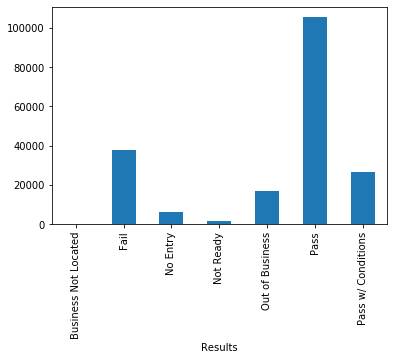

In [163]:
data.groupby('Results').count()['DBA Name'].plot.bar()

# Finding useful data in the Violations column
Violations seem to have the structure:
(&lt;violation number>. &lt;violation title> - &lt;violation comments> - | )+

According to https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF, critical violations are numbered 1-14, and serious violations are numbered 15-29. If these are found and fixed during the inspection, the inspection will pass with conditions. Otherwise it will fail.

In [247]:
data['Violations'][102762]

'18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS - Comments: OBSERVED EVIDENCE OF LIVE FRUIT FLIES INSIDE PREMISES. OBSERVED LIVE FRUIT FLIES ON WALLS AND CEILING IN BASEMENT. APPROXIMATELY 40 LIVE FRUIT FLIES WERE OBSERVED IN THIS AREAS. MUST CLEAN AND SANITIZE  AFFECTED AREAS. ADDITIONAL PEST CONTROL SERVICE IS NEEDED TO MINIMIZE OR ELIMINATE THE PEST ACTIVITY. SERIOUS VIOLATIOM 7-38-020. | 29. PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42-090 - Comments: PREVIOUS MINOR VIOLATIONS NOT CORRECTED FROM 09/09/13, REPORT#129655833. (33)OBSERVED THE FOLLOWING NOT CLEAN:INTERIOR OF CEILING,WALLS DOOR OF BASEMENT WALK IN COOLER,PREP COOLERS,ESPECIALLY THE HANDLES,DISH MACHINE,ALL FOOD EQUIPMENT ON 1ST FLOOR. 12/09/2013   (35) OPENINGS GOING DOWN WALL BEHIND DOOR LEADING TO BASEMENT.MUST SEAL TO PREVENT HIDING AREAS FOR PEST. SERIOUS VIOLATIONS NOT CORRECTED 7-42-090 | 30. FOOD IN ORIGINAL CONTAINER, PROPE

In [249]:
re_num = re.compile(r'([0-9]+)\.\s.*?\s\|')
violation_numbers = data['Violations'].apply(re_num.findall).apply(lambda xs: list(map(lambda x: int(x), xs)))
critical_violations = range(1,14+1)
serious_violations = range(15, 29+1)
violation_numbers
# Maybe we can actually connect violation numbers to result "Out of business"
# See under "Under what conditions will a food establishment get shut down?" https://dchealth.dc.gov/service/understanding-food-establishment-inspections
# While this is for Washington DC, I think it could apply to us too
# Also see "Results" in https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF

0                       [3, 5, 25, 50, 53, 53, 56]
1                                               []
2                                               []
3                                         [10, 55]
4                                         [54, 55]
                            ...                   
194899                                          []
194900                            [18, 32, 34, 35]
194901                                          []
194902    [18, 19, 32, 33, 34, 35, 36, 37, 38, 39]
194903                                          []
Name: Violations, Length: 194708, dtype: object

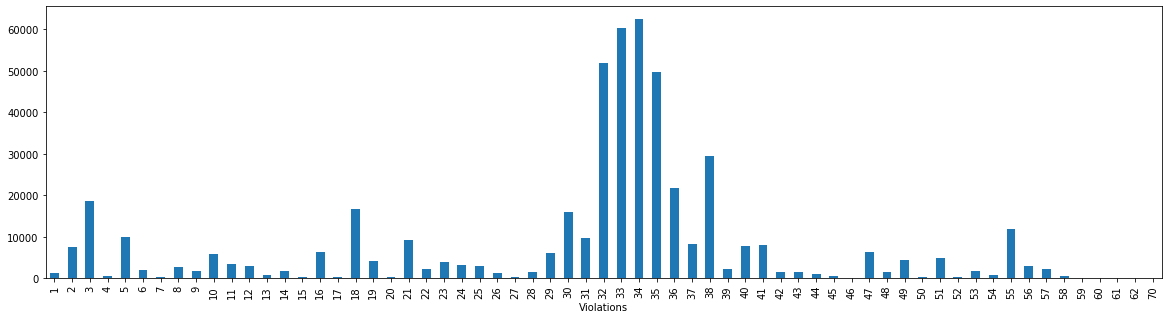

In [257]:
violation_numbers_exploded = violation_numbers.explode().dropna().sort_values()
violation_numbers_exploded.groupby(violation_numbers_exploded).count().plot.bar(figsize=(20,5))

In [258]:
violations_severity = violation_numbers.apply(lambda xs: list(map(lambda x: 'critical' if x in critical_violations else 'serious' if x in serious_violations else 'non-serious', xs)))
violations_severity = violations_severity.apply(lambda xs: ['no violation'] if len(xs) == 0 else xs)
violations_severity

0         [critical, critical, serious, non-serious, non...
1                                            [no violation]
2                                            [no violation]
3                                   [critical, non-serious]
4                                [non-serious, non-serious]
                                ...                        
194899                                       [no violation]
194900     [serious, non-serious, non-serious, non-serious]
194901                                       [no violation]
194902    [serious, serious, non-serious, non-serious, n...
194903                                       [no violation]
Name: Violations, Length: 194708, dtype: object

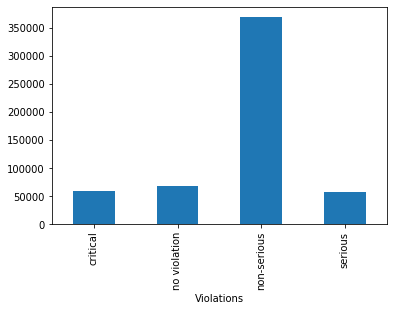

In [253]:
violations_severity_exploded = violations_severity.explode()
violations_severity_exploded.groupby(violations_severity_exploded).count().plot.bar()

# Supplementing the data

## Income by zip code (actually, anything by zip code if we want)
https://towardsdatascience.com/getting-census-data-in-5-easy-steps-a08eeb63995d

Attribution statement: This product uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.

Zip code 60666 is the zip code for O'Hare International Airport.
Zip code 60627 is the zip code for Golden Gate Park.
These do not have a household median income since nobody lives there.

In [ ]:
income_by_zip_address = "https://api.census.gov/data/%s/acs/acs5?key=%s&get=%s&for=zip%%20code%%20tabulation%%20area:%s" 
year = "2017" # 2009-2017
api_key = "" # Request here: https://www.census.gov/developers/
income_variable = "B19013_001E"
zip_codes = data['Zip'].drop_duplicates()

for zip_code in zip_codes:
    if pd.isnull(zip_code):
        continue
        
    called_api = income_by_zip_address % (year, api_key, income_variable, int(zip_code))
    response = requests.get(called_api)
    if response.status_code == 200:
        formatted_response = json.loads(response.text)
        print(formatted_response)
    else:
        print('Could not find income for zip code: ' + str(int(zip_code)))
    # add to some list or something, also exception handling
    

In [169]:
# chicago_map = gpd.read_file('data/chicago_zip.shp') # https://www.kaggle.com/threadid/chicago-shape-files

In [170]:
# ax = chicago_map.plot()
# g_data.plot(ax=ax, color='red')

# Projecting information on a map

## Coordinates
We want to be able to visualize our dataset on a map based on coordinates. This is done by using Folium.

In [65]:
data_names = data.groupby('DBA Name').first()
data_names = data_names[data_names['Zip'].apply(pd.isnull)]
print(len(data_names))

19


In [72]:
middle_lat = data_names.Latitude.median()
middle_lon = data_names.Longitude.median()
ch_map = folium.Map(location = [middle_lat, middle_lon], zoom_start=10)
locations = folium.map.FeatureGroup()
lats = data_names.Latitude
lons = data_names.Longitude
names = data_names.index


for lat, lon, name in list(zip(lats, lons, names))[0:10]:
    if np.isnan(lat) or np.isnan(lon):
        continue
    folium.Marker(
        location =  [lat, lon],
        tooltip = name,
        icon = folium.Icon(color='green', icon='info-sign')
    ).add_to(ch_map)
    
ch_map.add_child(locations)
print("Done")

Done


## Zip code areas
We use the zip code boundaries in a GeoJSON format from https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-ZIP-Codes/gdcf-axmw. We then simply overlay them on the map.

In [ ]:
ch_map = folium.Map(location = [middle_lat, middle_lon], zoom_start=10)

data_zip = data.groupby('Zip').count().reset_index()[['Zip', 'Risk']].rename(columns={'Risk':'Count'})
data_zip['Zip'] = data_zip['Zip'].apply(int).apply(str)
map_zip = gpd.read_file('data/chicago_zip.geojson')
map_zip = map_zip.merge(data_zip, left_on='zip', right_on='Zip')
zip_geojson = folium.GeoJson(map_zip)

ch_choropleth = folium.Choropleth(
    geo_data=map_zip,
    name='choropleth',
    data=data_zip,
    columns=['Zip', 'Count'],
    key_on='feature.properties.zip',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Number of inspections per Zip',
)

folium.GeoJsonTooltip(["Count"]).add_to(ch_choropleth.geojson)

ch_choropleth.add_to(ch_map)

#folium.LayerControl().add_to(ch_map)
ch_map

# Big companies and franchises vs small businesses
We use the list of US restaurant chains found here: https://en.wikipedia.org/wiki/List_of_restaurant_chains_in_the_United_States, which we convert to CSV using the tool here: https://wikitable2csv.ggor.de/.

## Facility Type
From https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF:

Type of facility: Each establishment is described by one of the following: bakery, banquet hall, candy store, caterer, coffee shop, day care center (for ages less than 2), day care center (for ages 2 – 6), day care center (combo, for ages less than 2 and 2 – 6 combined), gas station, Golden Diner, grocery store, hospital, long term care center(nursing home), liquor store, mobile food dispenser, restaurant, paleteria, school, shelter, tavern, social club, wholesaler, or Wrigley Field Rooftop. 

We created keywords for each type of facility. We also added ice cream, donut, and nan.

In [456]:
facility_types = data['Facility Type'].apply(str)
facility_types_unique = facility_types.drop_duplicates().reset_index(drop=True)

valid_facility_strings = ['bakery', 'banquet hall', 'candy', 'caterer', 'coffee', 'daycare', 'donut','gas station', 'golden diner', 'grocery', 'hospital', 'ice cream', 'long term', 'liquor store', 'mobile food', 'restaurant', 'paleteria', 'school', 'shelter', 'tavern', 'social club', 'wholesaler', 'wrigley field rooftop', 'nan']
print('Valid facility types')
print(facility_types_unique[facility_types_unique.apply(str.lower).map(lambda x: any([y in x for y in valid_facility_strings]))])
print('Invalid facility types')
print(facility_types_unique[facility_types_unique.apply(str.lower).map(lambda x: not any([y in x for y in valid_facility_strings]))])
# What to do? There are sooo many different facilities.

Valid facility types
0                           Restaurant
2                        Grocery Store
3      Daycare Above and Under 2 Years
4                Daycare (2 - 6 Years)
6                 Mobile Food Preparer
                    ...               
481                       candy/gelato
482                        CANDY MAKER
484                      TAVERN/LIQUOR
485                              Candy
487                   WHOLESALE BAKERY
Name: Facility Type, Length: 177, dtype: object
Invalid facility types
1      Children's Services Facility
5                          Catering
7                            Liquor
10      CHILDRENS SERVICES FACILITY
13                          BREWERY
                   ...             
479                    SOUP KITCHEN
480                    hooka lounge
483                       religious
486                       incubator
488                      Kids Cafe'
Name: Facility Type, Length: 312, dtype: object


In [475]:
def format_string(s): 
    return re.sub(r'[^a-z0-9\s]+', '', str.lower(s))

In [478]:
def group_type_from_string(types, strings):
    group = types.apply(format_string).map(lambda x: functools.reduce(lambda acc,b: b if b in x else acc, strings, 'invalid'))
    return group

In [479]:
facility_type_group = group_type_from_string(facility_types, valid_facility_strings)

In [480]:
data['Facility Type Group'] = facility_type_group
data

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Facility Type Group
0,2320509,TAQUERIA EL DORADO,2694960.0,Restaurant,Risk 1 (High),2114 W LAWRENCE AVE,60625.0,2019-10-25T00:00:00.000,License Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968820,-87.682292,restaurant
1,2320519,SALAM RESTAURANT,2002822.0,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,60625.0,2019-10-25T00:00:00.000,Complaint Re-Inspection,Pass,NaN,41.965719,-87.708538,restaurant
2,2320421,THE NEW GRACE RESTAURANT,2698310.0,Restaurant,Risk 1 (High),4409 N BROADWAY,60640.0,2019-10-24T00:00:00.000,License,Not Ready,NaN,41.962104,-87.655204,restaurant
3,2320368,GADS HILL CHILD CARE CENTER,2215799.0,Children's Services Facility,Risk 1 (High),2653 W OGDEN AVE,60608.0,2019-10-24T00:00:00.000,License,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.862273,-87.692703,invalid
4,2320389,"ALL THINGS ARE POSSIBLE FOR KIDS, INC.",2215965.0,Children's Services Facility,Risk 1 (High),4014 W CHICAGO AVE,60651.0,2019-10-24T00:00:00.000,License,Pass,54. GARBAGE & REFUSE PROPERLY DISPOSED; FACILI...,41.895468,-87.726665,invalid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194899,67732,WOLCOTT'S,1992039.0,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,60613.0,2010-01-04T00:00:00.000,License Re-Inspection,Pass,NaN,41.961606,-87.675967,restaurant
194900,67738,MICHAEL'S ON MAIN CAFE,2008948.0,Restaurant,Risk 1 (High),8750 W BRYN WAWR AVE,60631.0,2010-01-04T00:00:00.000,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,NaN,NaN,restaurant
194901,70269,mr.daniel's,1899292.0,Restaurant,Risk 1 (High),5645 W BELMONT AVE,60634.0,2010-01-04T00:00:00.000,License Re-Inspection,Pass,NaN,41.938443,-87.768318,restaurant
194902,104236,TEMPO CAFE,80916.0,Restaurant,Risk 1 (High),6 E CHESTNUT ST,60611.0,2010-01-04T00:00:00.000,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.898431,-87.628009,restaurant


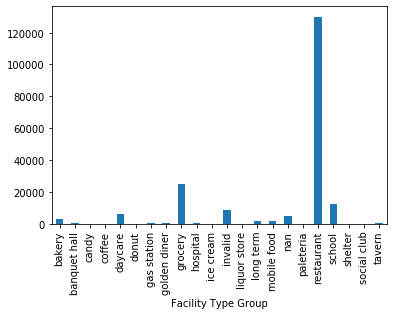

In [481]:
data.groupby('Facility Type Group').count()['DBA Name'].plot.bar()

We are interested in just the restaurants. However, there are some companies which are classified as both restaurants and another facility type. For example, Dunkin' Donuts are classified as both restaurant, bakery, donut and nan. We can see a similar problem affect McDonalds.

In [482]:
data[data['DBA Name'].apply(format_string) == 'dunkin donuts'].groupby('Facility Type Group').count()

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
Facility Type Group,,,,,,,,,,,,,
bakery,8,8,8,8,8,8,8,8,8,8,6,8,8
donut,8,8,8,8,8,8,8,8,8,8,7,8,8
nan,20,20,20,0,19,20,20,20,20,20,0,20,20
restaurant,1423,1423,1423,1423,1423,1423,1420,1423,1423,1423,1166,1406,1406


In [483]:
data[data['DBA Name'].apply(format_string) == 'mcdonalds'].groupby('Facility Type Group').count()

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
Facility Type Group,,,,,,,,,,,,,
nan,19,19,19,0,19,19,19,19,19,19,0,19,19
restaurant,1123,1123,1123,1123,1123,1123,1123,1123,1123,1123,885,1123,1123


We want to keep data loss to a minimum, therefor we decide to classify bakery, banquet hall, candy, coffee, donut, golden diner, ice cream, mobile food, nan, paleteria and tavern as restaurants, as we assume that these facility types can serve food, and could be counted as restaurants by an inspector. Note that nan is kind of a catch-all, and that things that are not restaurants may be included.

In [487]:
restaurant_equiv = ['restaurant', 'bakery', 'banquet hall', 'candy', 'coffee', 'donut', 'golden diner', 'ice cream', 'mobile food', 'nan', 'paleteria', 'tavern']
facility_type_group2 = group_type_from_string(facility_type_group, restaurant_equiv)
data['Facility Type Group'] = facility_type_group2
data = data[data['Facility Type Group'] != 'invalid']
data

/home/widmark/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Facility Type Group
0,2320509,TAQUERIA EL DORADO,2694960.0,Restaurant,Risk 1 (High),2114 W LAWRENCE AVE,60625.0,2019-10-25T00:00:00.000,License Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968820,-87.682292,restaurant
1,2320519,SALAM RESTAURANT,2002822.0,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,60625.0,2019-10-25T00:00:00.000,Complaint Re-Inspection,Pass,NaN,41.965719,-87.708538,restaurant
2,2320421,THE NEW GRACE RESTAURANT,2698310.0,Restaurant,Risk 1 (High),4409 N BROADWAY,60640.0,2019-10-24T00:00:00.000,License,Not Ready,NaN,41.962104,-87.655204,restaurant
5,2320442,CHOI'S CHINESE KITCHEN,2517136.0,Restaurant,Risk 1 (High),2638 N MILWAUKEE AVE,60647.0,2019-10-24T00:00:00.000,Canvass,Pass,37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER ...,41.929670,-87.708624,restaurant
6,2320427,HARMONY RESTAURANT,61757.0,Restaurant,Risk 1 (High),6525 W ARCHER AVE,60638.0,2019-10-24T00:00:00.000,Complaint Re-Inspection,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",41.792164,-87.785406,restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194899,67732,WOLCOTT'S,1992039.0,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,60613.0,2010-01-04T00:00:00.000,License Re-Inspection,Pass,NaN,41.961606,-87.675967,restaurant
194900,67738,MICHAEL'S ON MAIN CAFE,2008948.0,Restaurant,Risk 1 (High),8750 W BRYN WAWR AVE,60631.0,2010-01-04T00:00:00.000,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,NaN,NaN,restaurant
194901,70269,mr.daniel's,1899292.0,Restaurant,Risk 1 (High),5645 W BELMONT AVE,60634.0,2010-01-04T00:00:00.000,License Re-Inspection,Pass,NaN,41.938443,-87.768318,restaurant
194902,104236,TEMPO CAFE,80916.0,Restaurant,Risk 1 (High),6 E CHESTNUT ST,60611.0,2010-01-04T00:00:00.000,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.898431,-87.628009,restaurant


In [445]:
data = data[data['Facility Type'] == 'Restaurant']
data['Year'] = data['Inspection Date'].apply(lambda x: int(x[0:4]))
data

/home/widmark/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Facility Type Group,Year
0,2320509,TAQUERIA EL DORADO,2694960.0,Restaurant,Risk 1 (High),2114 W LAWRENCE AVE,60625.0,2019-10-25T00:00:00.000,License Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968820,-87.682292,restaurant,2019
1,2320519,SALAM RESTAURANT,2002822.0,Restaurant,Risk 1 (High),4634-4636 N KEDZIE AVE,60625.0,2019-10-25T00:00:00.000,Complaint Re-Inspection,Pass,NaN,41.965719,-87.708538,restaurant,2019
2,2320421,THE NEW GRACE RESTAURANT,2698310.0,Restaurant,Risk 1 (High),4409 N BROADWAY,60640.0,2019-10-24T00:00:00.000,License,Not Ready,NaN,41.962104,-87.655204,restaurant,2019
5,2320442,CHOI'S CHINESE KITCHEN,2517136.0,Restaurant,Risk 1 (High),2638 N MILWAUKEE AVE,60647.0,2019-10-24T00:00:00.000,Canvass,Pass,37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER ...,41.929670,-87.708624,restaurant,2019
6,2320427,HARMONY RESTAURANT,61757.0,Restaurant,Risk 1 (High),6525 W ARCHER AVE,60638.0,2019-10-24T00:00:00.000,Complaint Re-Inspection,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",41.792164,-87.785406,restaurant,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194899,67732,WOLCOTT'S,1992039.0,Restaurant,Risk 1 (High),1834 W MONTROSE AVE,60613.0,2010-01-04T00:00:00.000,License Re-Inspection,Pass,NaN,41.961606,-87.675967,restaurant,2010
194900,67738,MICHAEL'S ON MAIN CAFE,2008948.0,Restaurant,Risk 1 (High),8750 W BRYN WAWR AVE,60631.0,2010-01-04T00:00:00.000,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,NaN,NaN,restaurant,2010
194901,70269,mr.daniel's,1899292.0,Restaurant,Risk 1 (High),5645 W BELMONT AVE,60634.0,2010-01-04T00:00:00.000,License Re-Inspection,Pass,NaN,41.938443,-87.768318,restaurant,2010
194902,104236,TEMPO CAFE,80916.0,Restaurant,Risk 1 (High),6 E CHESTNUT ST,60611.0,2010-01-04T00:00:00.000,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.898431,-87.628009,restaurant,2010


In [488]:
def format_string(s): 
    return re.sub(r'[^a-z0-9\s]+', '', str.lower(s))

In [489]:
def group_type_from_string(types, strings):
    group = types.apply(format_string).map(lambda x: functools.reduce(lambda acc,b: b if b in x else acc, strings, 'invalid'))
    return group

In [490]:
restaurant_chains = pd.read_csv('data/restaurant_chains.csv')
restaurant_chains

,Name,Original location,Year started,Head office location,Number of worldwide locations,Areas served,Notes
0,Jollibee,"Quezon City, Philippines",1978,"Quezon City, Philippines","1,200","West, Mid-Atlantic, Hawaii",NaN
1,L&L Hawaiian Barbecue,"Honolulu, Hawaii",1976,"Honolulu, Hawaii",200+,"West, Southeast, New York, Hawaii, Alaska",NaN
2,Manchu Wok,"Peterborough, Ontario, Canada",1980,"Markham, Ontario, Canada",101,Nationwide,NaN
3,Noodles & Company,"Denver, Colorado",1995,"Broomfield, Colorado",460,Nationwide,NaN
4,Panda Express,"Glendale, California",1983,"Rosemead, California","2,000+",Nationwide,NaN
...,...,...,...,...,...,...,...
388,Sizzler,"Culver City, California",1958,"Mission Viejo, California",270,NaN,NaN
389,Western Sizzlin',"Augusta, Georgia",1962,"Roanoke, Virginia",54,NaN,NaN
390,Chuck E. Cheese's,"San Jose, California",1977,"Irving, Texas",608,Nationwide,NaN
391,Dave & Busters,"Dallas, Texas",1982,"Dallas, Texas",134,Nationwide,NaN


In [491]:
restaurant_chains_names = restaurant_chains['Name'].apply(format_string)
data_company = data.copy()
data_company['Company'] = group_type_from_string(data_company['DBA Name'], restaurant_chains_names)

In [492]:
data_chains = data_company[data_company['Company'] != 'invalid']
data_chains

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Facility Type Group,Company
9,2320383,ARGO TEA,1947515.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,60666.0,2019-10-24T00:00:00.000,Canvass Re-Inspection,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,42.008536,-87.914428,restaurant,argo tea
26,2320374,DUNKIN DONUTS/BASKIN ROBBINS,1909364.0,Restaurant,Risk 2 (Medium),6925 S PULASKI RD,60629.0,2019-10-24T00:00:00.000,Complaint Re-Inspection,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",41.766871,-87.722317,restaurant,dunkin donuts
38,2320352,MEXI-TACOS,2694744.0,Mobile Food Preparer,Risk 2 (Medium),2300 S THROOP ST,60608.0,2019-10-23T00:00:00.000,License Re-Inspection,Pass,NaN,41.850451,-87.658798,mobile food,cos
58,2320265,DOMINO'S PIZZA,2495920.0,Restaurant,Risk 2 (Medium),5016 S PULASKI RD,60632.0,2019-10-22T00:00:00.000,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.801787,-87.723555,restaurant,dominos
86,2320281,DUNKIN DONUTS,2698419.0,Restaurant,Risk 2 (Medium),201 W MADISON ST,60606.0,2019-10-22T00:00:00.000,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.881835,-87.633897,restaurant,dunkin donuts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194852,80208,Dunkin Donuts,2013340.0,Restaurant,Risk 1 (High),2800 W Lawrence AVE BLDG,60625.0,2010-01-05T00:00:00.000,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.968641,-87.698725,restaurant,dunkin donuts
194868,114256,STARBUCKS COFFEE #13710,1843207.0,Restaurant,Risk 2 (Medium),30 W ERIE ST,60654.0,2010-01-05T00:00:00.000,Canvass,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.894165,-87.629389,restaurant,starbucks
194873,164254,POPEYES CHICKEN,1798522.0,Restaurant,Risk 1 (High),7250 S WESTERN AVE,60636.0,2010-01-05T00:00:00.000,Short Form Complaint,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.761369,-87.683297,restaurant,popeyes
194891,158243,DUNKIN DONUTS,2013344.0,Restaurant,Risk 2 (Medium),970 W PERSHING RD,60609.0,2010-01-05T00:00:00.000,License,Fail,NaN,41.823504,-87.650666,restaurant,dunkin donuts


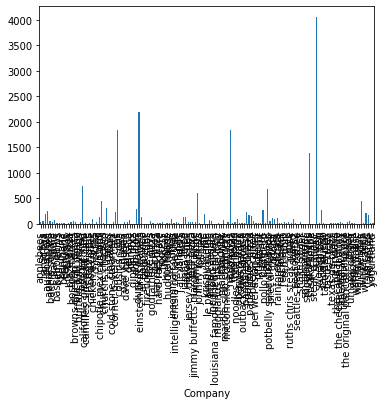

In [525]:
data_chains.groupby('Company').count()['DBA Name'].plot.bar()

We have a problem with company names like "Jack's" and "Roy's", since these are actual names, which can match with longer small business names. For example, "JACK'S FISH CHICKEN & MORE" is classified as "Jack's" for containing the name, but it has no association with the franchise "Jack's. 

In [526]:
data_chains[data_chains['Company'] == 'jacks']

,Inspection ID,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Facility Type Group,Company
2625,2304938,FRED & JACK'S EL GRAN BURRITO,66392.0,Restaurant,Risk 1 (High),7600 S YALE AVE,60620.0,2019-08-20T00:00:00.000,Canvass,Pass,41. WIPING CLOTHS: PROPERLY USED & STORED - Co...,41.756210,-87.631345,restaurant,jacks
4466,2300953,JACK'S ON HALSTED,53791.0,Restaurant,Risk 1 (High),3201 N HALSTED ST,60657.0,2019-07-11T00:00:00.000,Canvass,Out of Business,NaN,41.940038,-87.649121,restaurant,jacks
13024,2253175,JACKSON TAVERN,2397406.0,Restaurant,Risk 1 (High),216 W JACKSON BLVD,60606.0,2019-01-25T00:00:00.000,Canvass Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.878223,-87.634247,restaurant,jacks
13460,2252721,JACKSON TAVERN,2397406.0,Restaurant,Risk 1 (High),216 W JACKSON BLVD,60606.0,2019-01-17T00:00:00.000,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.878223,-87.634247,restaurant,jacks
14955,2243236,FRED & JACK'S EL GRAN BURRITO,66392.0,Restaurant,Risk 1 (High),7600 S YALE AVE,60620.0,2018-12-07T00:00:00.000,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.756210,-87.631345,restaurant,jacks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188642,229410,SILK ROAD JACKSON CORPORATION,31399.0,Restaurant,Risk 1 (High),216 W JACKSON BLVD,60606.0,2010-05-13T00:00:00.000,Canvass,Pass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.878223,-87.634247,restaurant,jacks
191623,68336,BOB & JACK'S PIZZA INC,44469.0,Restaurant,Risk 1 (High),10244 S EWING AVE,60617.0,2010-03-15T00:00:00.000,Out of Business,Fail,NaN,41.708706,-87.535435,restaurant,jacks
191790,229298,THE JACKSON GRILL,10130.0,NaN,Risk 1 (High),547 W JACKSON BLVD,60661.0,2010-03-10T00:00:00.000,Out of Business,Pass,NaN,41.877914,-87.641405,nan,jacks
192426,229255,JACKSON OTB,42186.0,NaN,Risk 1 (High),223 W JACKSON BLVD,60606.0,2010-02-24T00:00:00.000,Out of Business,Pass,NaN,41.878002,-87.634409,nan,jacks


In [527]:
data_small_business = data_company[data_company['Company'] == 'invalid']

We group the datasets by results, count them, and dividing them by their length to see what the distribution of the results are.  

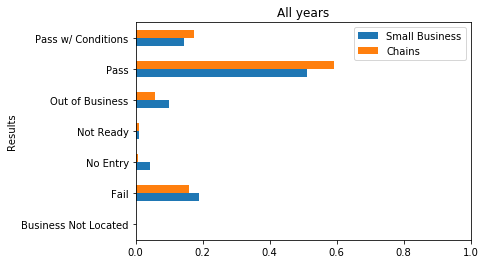

In [528]:
dsb_size = len(data_small_business)
dc_size = len(data_chains)
results_vs = pd.DataFrame()
results_vs['Small Business'] = data_small_business.groupby('Results').count()['DBA Name'].apply(lambda x: x/dsb_size)
results_vs['Chains'] = data_chains.groupby('Results').count()['DBA Name'].apply(lambda x: x/dc_size)
ax = plt.gca()
ax.set_xlim(0,1)
results_vs.plot.barh(title='All years', ax=ax)

#fig, ax_list = plt.subplots(4,3, figsize=(30,20))
#
# for i, year in enumerate(data['Year'].sort_values().unique()):
#     ax = ax_list[int(i/3)][i%3]
#     ax.set_xlim(0,1)
#     results_vs = pd.DataFrame()
#     dsb_size = len(data_small_business[data_small_business['Year'] == year])
#     dc_size = len(data_chains[data_chains['Year'] == year])
#     results_vs['Small Business'] = data_small_business[data_small_business['Year'] == year].groupby('Results').count()['DBA Name'].apply(lambda x: x/dsb_size)
#     results_vs['Chains'] = data_chains[data_chains['Year'] == year].groupby('Results').count()['DBA Name'].apply(lambda x: x/dc_size)
#     results_vs.plot.barh(title=year, ax=ax)

As we can see, chains generally pass inspections more often than small businesses, and fail less often.

We quantize a bit by setting "Pass" as both "Pass" and "Pass w/ Conditions", and "Fail" as "Fail" and "Out of business".

Pass: Chains/Small businesses: 1.120586546268243


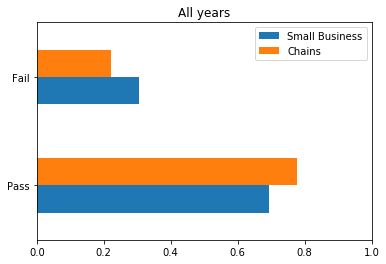

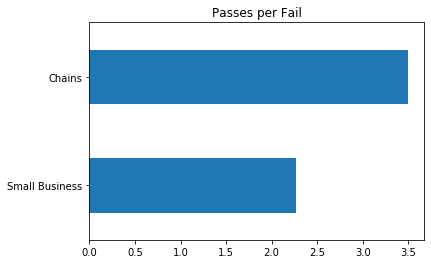

In [529]:
dsb_size = len(data_small_business)
dc_size = len(data_chains)
results_percentage = pd.DataFrame(columns=['Small Business', 'Chains'])
results_percentage.loc['Pass'] = results_vs.loc['Pass']+results_vs.loc['Pass w/ Conditions']
results_percentage.loc['Fail'] = results_vs.loc['Fail']+results_vs.loc['Out of Business']
results_percentage = results_percentage.div(results_percentage.sum(axis=0), axis=1)
plt.figure(0)
ax = plt.gca()
ax.set_xlim(0,1)
results_percentage.plot.barh(title='All years', ax=ax)
plt.figure(1)
passes_per_fail = results_percentage.loc['Pass']/results_percentage.loc['Fail']
passes_per_fail.plot.barh(title='Passes per Fail')
print("Pass: Chains/Small businesses: " + str(results_percentage.loc['Pass']['Chains']/results_percentage.loc['Pass']['Small Business']))


Our measurement tells us that chains are 12\% safer than small businesses.

In [530]:
middle_lat = data_small_business.Latitude.median()
middle_lon = data_small_business.Longitude.median()

ch_map = folium.Map(location = [middle_lat, middle_lon], zoom_start=10)
data_zip_chains = data_chains.groupby(['Zip', 'Address']).first().reset_index()[['Zip', 'DBA Name']].groupby('Zip').count().rename(columns={'DBA Name':'Count C'})
data_zip_sb = data_small_business.groupby(['Zip', 'Address']).first().reset_index()[['Zip', 'DBA Name']].groupby('Zip').count().rename(columns={'DBA Name':'Count SB'})
data_zip = data_zip_sb.join(data_zip_chains, how='outer')
data_zip['Chain per small business'] = data_zip['Count C']/data_zip['Count SB']
data_zip = data_zip.fillna(0)
data_zip = data_zip.reset_index()
data_zip['Zip'] = data_zip['Zip'].apply(int).apply(str)
map_zip = gpd.read_file('data/chicago_zip.geojson')
map_zip = map_zip.merge(data_zip, left_on='zip', right_on='Zip')
zip_geojson = folium.GeoJson(map_zip)

ch_choropleth = folium.Choropleth(
    geo_data=map_zip,
    name='choropleth',
    data=data_zip,
    columns=['Zip', 'Chain per small business'],
    key_on='feature.properties.zip',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Chain per small business per zip code',
)

folium.GeoJsonTooltip(["Chain per small business", "Zip"]).add_to(ch_choropleth.geojson)

ch_choropleth.add_to(ch_map)

#folium.LayerControl().add_to(ch_map)
ch_map